In [0]:
from google.colab import drive
drive.mount('/content/drive')

# Modules

## tensorflow_detection_api

In [0]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import numpy as np

import cv2
import time


class DetectorAPI:
    def __init__(self, path_to_ckpt):
        self.path_to_ckpt = path_to_ckpt

        self.detection_graph = tf.Graph()
        with self.detection_graph.as_default():
            od_graph_def = tf.GraphDef()
            with tf.gfile.GFile(self.path_to_ckpt, 'rb') as fid:
                serialized_graph = fid.read()
                od_graph_def.ParseFromString(serialized_graph)
                tf.import_graph_def(od_graph_def, name='')

        self.default_graph = self.detection_graph.as_default()
        self.sess = tf.Session(graph=self.detection_graph)

        # Definite input and output Tensors for detection_graph
        self.image_tensor = self.detection_graph.get_tensor_by_name('image_tensor:0')
        # Each box represents a part of the image where a particular object was detected.
        self.detection_boxes = self.detection_graph.get_tensor_by_name('detection_boxes:0')
        # Each score represent how level of confidence for each of the objects.
        # Score is shown on the result image, together with the class label.
        self.detection_scores = self.detection_graph.get_tensor_by_name('detection_scores:0')
        self.detection_classes = self.detection_graph.get_tensor_by_name('detection_classes:0')
        self.num_detections = self.detection_graph.get_tensor_by_name('num_detections:0')

    def processFrame(self, image):
        # Expand dimensions since the trained_model expects images to have shape: [1, None, None, 3]
        image_np_expanded = np.expand_dims(image, axis=0)
        # Actual detection.
        start_time = time.time()
        (boxes, scores, classes, num) = self.sess.run(
            [self.detection_boxes, self.detection_scores, self.detection_classes, self.num_detections],
            feed_dict={self.image_tensor: image_np_expanded})
        end_time = time.time()

        print("Elapsed Time:", end_time-start_time)

        im_height, im_width,_ = image.shape
        
        boxes_list = [None for i in range(boxes.shape[1])]
        for i in range(boxes.shape[1]):
            boxes_list[i] = (int(boxes[0,i,0] * im_height),
                        int(boxes[0,i,1]*im_width),
                        int(boxes[0,i,2] * im_height),
                        int(boxes[0,i,3]*im_width))

        return boxes_list, scores[0].tolist(), [int(x) for x in classes[0].tolist()], int(num[0])
    
    def drawTrail(self, pts_dict, image):
        for img_ids in pts_dict.keys():
            pts = pts_dict[img_ids]
            for i in range(1,len(pts)):
                if pts[i - 1] is None or pts[i] is None:
                    continue
                cv2.line(image, pts[i - 1], pts[i], (0, 0, 205), 2)
        return image

    def close(self):
        self.sess.close()
        self.default_graph.close()


## centroid_tracking

In [0]:
from scipy.spatial import distance as dist
from collections import OrderedDict
import numpy as np
class CentroidTracker():
    def __init__(self, maxDisappeared=20):
        # initialize the next unique object ID along with two ordered
        # dictionaries used to keep track of mapping a given object
        # ID to its centroid and number of consecutive frames it has
        # been marked as "disappeared", respectively
        self.nextObjectID = 0
        self.objects = OrderedDict()
        self.disappeared = OrderedDict()
        # store the number of maximum consecutive frames a given
        # object is allowed to be marked as "disappeared" until we
        # need to deregister the object from tracking
        self.maxDisappeared = maxDisappeared
    def register(self, centroid):
        # when registering an object we use the next available object
        # ID to store the centroid
        self.objects[self.nextObjectID] = centroid
        self.disappeared[self.nextObjectID] = 0
        self.nextObjectID += 1
    def deregister(self, objectID):
        # to deregister an object ID we delete the object ID from
        # both of our respective dictionaries
        del self.objects[objectID]
        del self.disappeared[objectID]
    def update(self, rects):
        # check to see if the list of input bounding box rectangles
        # is empty
        if len(rects) == 0:
            # loop over any existing tracked objects and mark them
            # as disappeared
            for objectID in list(self.disappeared.keys()):
                self.disappeared[objectID] += 1
                # if we have reached a maximum number of consecutive
                # frames where a given object has been marked as
                # missing, deregister it
                if self.disappeared[objectID] > self.maxDisappeared:
                    self.deregister(objectID)
            # return early as there are no centroids or tracking info
            # to update
            return self.objects
        inputCentroids = np.zeros((len(rects), 2), dtype="int")
        # loop over the bounding box rectangles
#         print(enumerate(rects))
        
        for (i, (startX, startY, endX, endY)) in enumerate(rects):
            # use the bounding box coordinates to derive the centroid
            cX = int((startX + endX) / 2.0)
            cY = int((startY + endY) / 2.0)
            inputCentroids[i] = (cX, cY)
        if len(self.objects) == 0:
            for i in range(0, len(inputCentroids)):
                self.register(inputCentroids[i])
                        # otherwise, are are currently tracking objects so we need to
        # try to match the input centroids to existing object
        # centroids
        else:
            # grab the set of object IDs and corresponding centroids
            objectIDs = list(self.objects.keys())
            objectCentroids = list(self.objects.values())
            # compute the distance between each pair of object
            # centroids and input centroids, respectively -- our
            # goal will be to match an input centroid to an existing
            # object centroid
            D = dist.cdist(np.array(objectCentroids), inputCentroids)
            # in order to perform this matching we must (1) find the
            # smallest value in each row and then (2) sort the row
            # indexes based on their minimum values so that the row
            # with the smallest value is at the *front* of the index
            # list
            rows = D.min(axis=1).argsort()
            # next, we perform a similar process on the columns by
            # finding the smallest value in each column and then
            # sorting using the previously computed row index list
            cols = D.argmin(axis=1)[rows]
            # in order to determine if we need to update, register,
            # or deregister an object we need to keep track of which
            # of the rows and column indexes we have already examined
            usedRows = set()
            usedCols = set()
            # loop over the combination of the (row, column) index
            # tuples
            for (row, col) in zip(rows, cols):
                # if we have already examined either the row or
                # column value before, ignore it
                # val
                if row in usedRows or col in usedCols:
                    continue
                # otherwise, grab the object ID for the current row,
                # set its new centroid, and reset the disappeared
                # counter
                objectID = objectIDs[row]
                self.objects[objectID] = inputCentroids[col]
                self.disappeared[objectID] = 0
                # indicate that we have examined each of the row and
                # column indexes, respectively
                usedRows.add(row)
                usedCols.add(col)
                # compute both the row and column index we have NOT yet
            # examined
            unusedRows = set(range(0, D.shape[0])).difference(usedRows)
            unusedCols = set(range(0, D.shape[1])).difference(usedCols)
                        # in the event that the number of object centroids is
            # equal or greater than the number of input centroids
            # we need to check and see if some of these objects have
            # potentially disappeared
            if D.shape[0] >= D.shape[1]:
                # loop over the unused row indexes
                for row in unusedRows:
                    # grab the object ID for the corresponding row
                    # index and increment the disappeared counter
                    objectID = objectIDs[row]
                    self.disappeared[objectID] += 1
                    # check to see if the number of consecutive
                    # frames the object has been marked "disappeared"
                    # for warrants deregistering the object
                    if self.disappeared[objectID] > self.maxDisappeared:
                        self.deregister(objectID)
            # otherwise, if the number of input centroids is greater
            # than the number of existing object centroids we need to
            # register each new input centroid as a trackable object
            else:
                for col in unusedCols:
                    self.register(inputCentroids[col])
        # return the set of trackable objects
        return self.objects

## people_in_box

In [0]:
from collections import OrderedDict
import numpy as np

class People_In_Box(object):
  
    # Class to detect people in a box
    def __init__(self, frame, centers, rects):
        # self.people_in_box = 0
        self.frame = frame
        self.centers = centers
        self.rects = rects

    # Function to count the people in the box
    def count_people_in_box(self, x1, y1, x2, y2):
      people_in_box = 0
      # pts = []
      pid = 0
      pids = []

      # Extracting the coordinates from the centroids
      for x, y in self.centers:
          cX = x
          cY = y
          
          # Increasing count of people inside the box
          if cX > x1 and cX < x2 and cY > y1 and cY < y2:
              people_in_box += 1
              # pts.append([cX, cY])
              pids.append(pid)
              
          pid += 1

      # Returning the count, centroid index and centroid coordinates
      return people_in_box, pids

    # Function to merge group with common pids
    def merge(self, lists, results=None):

      if results is None:
          results = []

      if not lists:
          return results

      first = lists[0]
      merged = []
      output = []

      for li in lists[1:]:
          for i in first:
              if i in li:
                  merged = merged + li
                  break
          else:
              output.append(li)

      merged = merged + first
      results.append(list(set(merged)))

      return merge(output, results)
        
    # Function to detect group in the frame
    def detect_group(self, threshold):
      """
      detect groups of people based on the centroid distance threshold
      output: groups of indices of centers
      """
      groups = []
      # gid = 0
      # pid = 0

      # Extracting the coordinates from the centroids
      for x, y in self.centers:
        x1 = x - threshold
        y1 = y - threshold
        x2 = x + threshold
        y2 = y + threshold

        # Extracting group information
        count, pid_in_group = self.count_people_in_box(x1, y1, x2, y2)
        # print(pid_in_group)
        groups.append(pid_in_group)

      # Returning groups of indices of centers
      return self.merge(groups)

    # Function to count the people in group and construct group bounding box
    def count_people_in_group(self, groups):

      people_in_group = 0
      people_alone = 0
      group_boxs = []
      margin = 5

      if len(groups) > 0:

        for cluster in groups:
          
          # Calculate bounding box coordinates of groups in the frame
          if len(cluster) > 1:
            people_in_group += len(cluster)
            boxs = [self.rects[i] for i in cluster]
            boxs = np.stack(boxs, axis=1)

            x1 = max(min(boxs[1])-margin, 1)
            y1 = max(min(boxs[0])-margin, 1)
            x2 = min(max(boxs[3])+margin, self.frame.shape[1] - 1)
            y2 = min(max(boxs[2])+margin, self.frame.shape[0] - 1)
            
            group_boxs.append([x1,y1,x2,y2])

          else:
            people_alone += 1

      return people_in_group, people_alone, group_boxs

In [0]:
people_inside = People_In_Box(img, rects_centers, rects)
count, _ = people_inside.count_people_in_box(150, 100, 500, 450)

In [117]:
groups = people_inside.detect_group(40)
peopleInGroup, peopleAlone, group_boxs = people_inside.count_people_in_group(groups)

[0, 1]
[0, 1]
[2, 3]
[2, 3, 4]
[3, 4]


In [119]:
print(group_boxs)

[[568, 226, 645, 336], [366, 171, 459, 275]]


In [0]:
for box in group_boxs:
  cv2.rectangle(img, (box[0],box[1]),(box[2],box[3]),(225, 225, 51),2)

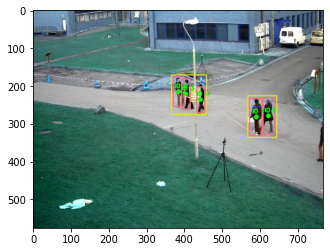

In [121]:
plt.imshow(img)
plt.show()


# Main

In [5]:
import cv2
import os, sys
import numpy as np
from  matplotlib import pyplot as plt
from collections import defaultdict 

print("Done")

Done


In [0]:
# Initialise

img_path = 'drive/My Drive/comp9517/sequence'
out_path = 'drive/My Drive/comp9517/output/'
model_path = 'drive/My Drive/comp9517/faster_rcnn_inception_v2_coco_2018_01_28/frozen_inference_graph.pb'

writeVideo_flag = False
out_video = 'tensor_video_counting.mp4'

# counter = 0

odapi = DetectorAPI(path_to_ckpt=model_path)
threshold = 0.7

np.random.seed(123)
color = np.random.choice(range(256), size=3)
color = [int(c) for c in color]

# define box for task 2- to be changed to stdin input
bxx = 150
bxy = 100
bxw = 450
bxh = 350

fps = 20

In [0]:
def get_file_names(img_path):
    
    files = []    
    for (dirpath, dirnames, filenames) in os.walk(img_path):
        for file in filenames:
            files.append(file)
    
    return files

In [0]:
def save_to_video():
  print("saving to video..")
  out_files = get_file_names(out_path)
  out_files.sort()

  img = cv2.imread(os.path.join(out_path, out_files[0]))
  height , width , layers =  img.shape
  
  # fourcc =  cv2.VideoWriter_fourcc('M', 'J', 'P', 'G')
  fourcc = cv2.VideoWriter_fourcc(*'mp4v')
  
  out = cv2.VideoWriter(out_video, fourcc, fps, (width,height))
  
  print("output video...")
  for f in out_files:
      img = cv2.imread(os.path.join(out_path, f))
      img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
      out.write(img)
      
  out.release()
  cv2.destroyAllWindows()

In [0]:
filenames = get_file_names(img_path)
filenames.sort()
# filenames[:10]

In [132]:
# if __name__ == "__main__":

start = time.time()

frame_array = []
ct = CentroidTracker()
#Default dictionary of format {id:[[centroid[0],centroid[1]],..], id[...]}
pts_dict = defaultdict(list)

for f in filenames[39:40]:

    if not f.lower().endswith(('.bmp', '.jpeg', '.jpg', '.png', '.tif', '.tiff')):
            continue

    print(f)

    img = cv2.imread(os.path.join(img_path,f))

    # Start Task 1
    # Results of pretrained frcnn detection. 
    boxes, scores, classes, num = odapi.processFrame(img)

    rects = []
    rects_centers = []
    n = 0

    for i in range(len(boxes)):
        # keep bounding boxes of human (Class 1) with probability above threshold 
        # and height greater than 50 
        if classes[i] == 1  and scores[i] > threshold and (boxes[i][2] - boxes[i][0]) > 50:

            box = boxes[i]
            # x1 = box[1]
            # y1 = box[0]
            # x2 = box[3]
            # y2 = box[2]

            cv2.rectangle(img,(box[1],box[0]),(box[3],box[2]),(color),2)
            rects.append(box)

            cx = int((box[1]+box[3])/2)
            cy = int((box[0]+box[2])/2)
            cv2.circle(img,(cx, cy),5,(color),-1)
            rects_centers.append([cx, cy])

            # number of pedestrian detected
            n += 1

    objects = ct.update(rects)
    centers=[]
    # loop over the tracked objects
    for (objectID, centroid) in objects.items():
        # draw both the ID of the object and the centroid of the
        # object on the output frame
        text = "ID {}".format(objectID)
        cv2.putText(img, text, (centroid[1] - 10, centroid[0] - 10),
            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
        cv2.circle(img, (centroid[1], centroid[0]), 4, (0, 255, 0), 4)
        centers.append([centroid[1],centroid[0]])          
        pts_dict[objectID].append((centroid[1], centroid[0]))
        img = odapi.drawTrail(pts_dict , img)  
        
    print('finish detection and tracking...')

    # End Task 1


    # Start Task 2 - return the count of the people inside the drawn box

    # Initialise Constructor for the People in Box Tracker
    people_inside = People_In_Box(img, rects_centers, rects)

    peopleInBox, _ = people_inside.count_people_in_box(bxx, bxy, bxx+bxw, bxy+bxh)
                                             
    # draw user defined bounding rectangle
    cv2.rectangle(img, (bxx, bxy), (bxx+bxw, bxy+bxh), 
                  (255,255,204), 1)
    
    print('finish counting in the box..')
    
    # End Task 2


    # Start Task 3

    # select centroid distance of 40 as group detection threshold
    groups = people_inside.detect_group(40)
    peopleInGroup, peopleAlone, group_boxs = people_inside.count_people_in_group(groups)
    
    # draw group bounding boxes
    for box in group_boxs:
      cv2.rectangle(img,(box[0],box[1]),(box[2],box[3]),(225, 225, 51),2)

    # Show the count on frame
    text_color = [50, 255, 0]
    (text_width, text_height), baseline = cv2.getTextSize(
            'people detected: ', cv2.FONT_HERSHEY_SIMPLEX, 0.6, 2)
    cv2.putText(img, 'people detected: ' + str(n), 
                (10, 20+(text_height+5)),
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (text_color), 2)
    cv2.putText(img, 'people in box: ' + str(peopleInBox), 
                (10, 20+(text_height+5)*2),
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (text_color), 2)
    cv2.putText(img, 'groups detected: ' + str(len(groups)), 
                (10, 20+(text_height+5)*3),
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (text_color), 2)
    cv2.putText(img, 'people in groups: ' + str(peopleInGroup), 
                (10, 20+(text_height+5)*4),
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (text_color), 2)
    cv2.putText(img, 'people alone: ' + str(peopleAlone), 
                (10, 20+(text_height+5)*5),
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (text_color), 2)

    frame_array.append(img)

    cv2.imwrite(os.path.join(out_path,f), img)

    print('end of', f)
    print('\n')

cv2.destroyAllWindows()

end = time.time()
print('run time:', (end-start))

000040.jpg
Elapsed Time: 1.2697255611419678
finish detection and tracking...
finish counting in the box..
[0, 1]
[0, 1]
[2, 3]
[2, 3, 4]
[3, 4]
end of 000040.jpg


run time: 1.3060424327850342


In [0]:
if writeVideo_flag:
  save_to_video()

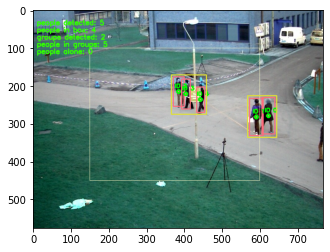

In [133]:
plt.imshow(frame_array[0])
plt.show()

In [0]:
if __name__ == '__main__':
    main()